# CNN Trainig Templete
## Based on Tensorlfow - CNN MNIST example
https://github.com/tensorflow/tensorflow/blob/r1.6/tensorflow/examples/tutorials/layers/cnn_mnist.py

## 필요한 library 호출

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import random
from sklearn.cross_validation import train_test_split
from datetime import datetime
tf.logging.set_verbosity(tf.logging.INFO)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
width = 512
height = 512
channel = 3
total_pix = width * height * channel

In [3]:
def cnn_model_fn(features, labels, mode):
    
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, height, width, channels]
    # Our Fishing net image size is 640x480 and 3-channel (RGB)
    #input_layer = tf.reshape(features["x"], [-1, 480, 640, 3])
    input_layer = tf.reshape(features["x"], [-1, 512, 512, 3])

    # Convolutional Layer #1
    # Computes 48 features using a 5x5 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 480, 640, 3]
    # Output Tensor Shape: [batch_size, 480, 640, 48]
    conv1 = tf.layers.conv2d(
        
        inputs=input_layer,
        filters=48,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    

    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 480, 640, 48]
    # Output Tensor Shape: [batch_size, 240, 320, 48]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    

    # Convolutional Layer #2
    # Computes 96 features using a 5x5 filter.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 240, 320, 48]
    # Output Tensor Shape: [batch_size, 240, 320, 96]
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=96,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    

    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 240, 320, 96]
    # Output Tensor Shape: [batch_size, 120, 160, 96]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    

    
    
    
    # Input Tensor Shape: [batch_size, 120, 160, 96]
    # Output Tensor Shape: [batch_size, 120, 160, 96]    
    conv3 = tf.layers.conv2d(
        inputs=pool2,
        filters=96,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    
    # Input Tensor Shape: [batch_size, 120, 160, 96]
    # Output Tensor Shape: [batch_size, 60, 80, 96]
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
    
    
    
    
    # Input Tensor Shape: [batch_size, 60, 80, 96]
    # Output Tensor Shape: [batch_size, 60, 80, 96]    
    conv4 = tf.layers.conv2d(
        inputs=pool3,
        filters=96,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    
    # Input Tensor Shape: [batch_size, 60, 80, 96]
    # Output Tensor Shape: [batch_size, 30, 40, 96]
    pool4 = tf.layers.max_pooling2d(inputs=conv4, pool_size=[2, 2], strides=2)
    
    
    
    
    # Input Tensor Shape: [batch_size, 30, 40, 96]
    # Output Tensor Shape: [batch_size, 30, 40, 96]    
    conv5 = tf.layers.conv2d(
        inputs=pool4,
        filters=96,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    
    # Input Tensor Shape: [batch_size, 30, 40, 96]
    # Output Tensor Shape: [batch_size, 15, 20, 96]
    pool5 = tf.layers.max_pooling2d(inputs=conv5, pool_size=[2, 2], strides=2)
    
    
    
    
    
    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 15, 20, 96]
    # Output Tensor Shape: [batch_size, 15 * 20 * 96]
    #pool5_flat = tf.reshape(pool5, [-1, 15 * 20 * 96])
    pool5_flat = tf.reshape(pool5, [-1, 16 * 16 * 96])
    


    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 15 * 20 * 96]
    # Output Tensor Shape: [batch_size, 1024]
    dense = tf.layers.dense(inputs=pool5_flat, units=1024, activation=tf.nn.relu)
    

    # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 1]
    logits = tf.layers.dense(inputs=dropout, units=2)
    

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    # sparse_softmax_cross_entropy cannot use one-hot encoding
    
    #loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

## Code Run


### Training
Batch size: 128  
Epoch: 5  
Shuffle: True  
Step: 20000

## Loading dataset
Load dataset and split them into training data and evaluation data

In [4]:
def data_process(d_dir, split_rate):
    
    num_class = len(d_dir.keys())

    out = {}
    

    for i in range(num_class):
        x_train, x_test = train_test_split(d_dir[i], test_size=split_rate)
        
        if i == 0:
            train_temp = x_train
            test_temp = x_test
        else:
            train_temp.extend(x_train)
            test_temp.extend(x_test)
    
    random.shuffle(train_temp)
    out['train'] = train_temp
    random.shuffle(test_temp)
    out['test'] = test_temp
    
    return out

In [5]:
image_dir1 = '/dataset/'
class_name1 = ['untorn', 'torn']

data_dir1 = {}
for i in range(len(class_name1)):
    temp_dir = image_dir1 + class_name1[i]
    img_files = [[os.path.join(temp_dir, f), np.int16(i)] for f in os.listdir(temp_dir) if f.endswith('.png')]
    data_dir1[i] = img_files
print(len(data_dir1[0]), len(data_dir1[1]))

1780 1485


In [6]:
tr_data_dir = data_process(data_dir1, 0.2)

In [7]:
tr_data = np.zeros((len(tr_data_dir['train']), total_pix), dtype=np.float32)
tr_label = np.zeros((len(tr_data_dir['train']), 1), dtype=np.int32)

for i in range(len(tr_data_dir['train'])):
    img = cv2.imread(tr_data_dir['train'][i][0])
    img2 = cv2.resize(img, (512, 512), interpolation=cv2.INTER_CUBIC)
    tr_data[i,:] = img2.flatten()
    tr_label[i] = tr_data_dir['train'][i][1]

In [8]:
ev_data = np.zeros((len(tr_data_dir['test']), total_pix), dtype=np.float32)
ev_label = np.zeros((len(tr_data_dir['test']), 1), dtype=np.int32)

for i in range(len(tr_data_dir['test'])):
    img = cv2.imread(tr_data_dir['test'][i][0])
    img2 = cv2.resize(img, (512, 512), interpolation=cv2.INTER_CUBIC)
    ev_data[i,:] = img2.flatten()
    ev_label[i] = tr_data_dir['test'][i][1]

In [11]:
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# Create the Estimator
net_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/models/CNN2600-0605_RGB")

# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

batch_s = 16
epochs = 10
tr_steps = int(tr_data.shape[0]/batch_s*epochs)
in_steps = 1


# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": tr_data},
    y=tr_label,
    batch_size=batch_s,
    num_epochs=epochs,
    shuffle=True)
net_classifier.train(
    input_fn=train_input_fn,
    steps=tr_steps,
    hooks=[logging_hook])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_global_id_in_cluster': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f37438146d8>, '_evaluation_master': '', '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_master': '', '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_num_worker_replicas': 1, '_session_config': None, '_service': None, '_log_step_count_steps': 100, '_model_dir': '/models/CNN2600-0605_RGB', '_is_chief': True, '_task_id': 0, '_task_type': 'worker', '_tf_random_seed': None}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-163
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1

INFO:tensorflow:step = 864, loss = 0.8647429 (24.403 sec)
INFO:tensorflow:probabilities = [[0.8432076  0.15679239]
 [0.770615   0.22938506]
 [0.77983963 0.22016032]
 [0.50128794 0.49871206]
 [0.6443415  0.35565844]
 [0.92039025 0.07960974]
 [0.2087868  0.7912132 ]
 [0.36504054 0.63495946]
 [0.524515   0.47548503]
 [0.8948698  0.10513019]
 [0.27691355 0.7230864 ]
 [0.5373421  0.4626579 ]
 [0.9156073  0.0843927 ]
 [0.9203987  0.07960132]
 [0.9667222  0.03327785]
 [0.39524865 0.6047514 ]] (12.240 sec)
INFO:tensorflow:global_step/sec: 4.09039
INFO:tensorflow:probabilities = [[0.2738873  0.7261127 ]
 [0.2646691  0.73533094]
 [0.6656959  0.3343041 ]
 [0.9150507  0.0849493 ]
 [0.80913883 0.1908611 ]
 [0.7783278  0.22167216]
 [0.9147243  0.08527568]
 [0.24934913 0.7506509 ]
 [0.4819147  0.5180853 ]
 [0.34304747 0.6569525 ]
 [0.9373711  0.06262892]
 [0.22568578 0.7743142 ]
 [0.6604026  0.33959746]
 [0.355295   0.64470506]
 [0.50942147 0.49057853]
 [0.5706152  0.42938486]] (12.208 sec)
INFO:tens

INFO:tensorflow:global_step/sec: 4.09303
INFO:tensorflow:probabilities = [[0.26449606 0.735504  ]
 [0.20847638 0.7915236 ]
 [0.5234816  0.4765184 ]
 [0.42333254 0.5766675 ]
 [0.6713387  0.3286613 ]
 [0.3486053  0.6513947 ]
 [0.7925339  0.20746614]
 [0.82951915 0.17048086]
 [0.85296905 0.14703089]
 [0.71613026 0.2838697 ]
 [0.88847315 0.11152683]
 [0.25901183 0.7409882 ]
 [0.22309801 0.776902  ]
 [0.8715954  0.12840459]
 [0.25141874 0.7485813 ]
 [0.2290155  0.7709845 ]] (12.139 sec)
INFO:tensorflow:step = 1764, loss = 0.47683772 (24.433 sec)
INFO:tensorflow:Saving checkpoints for 1795 into /models/CNN2600-0605_RGB/model.ckpt.
INFO:tensorflow:Loss for final step: 0.489512.


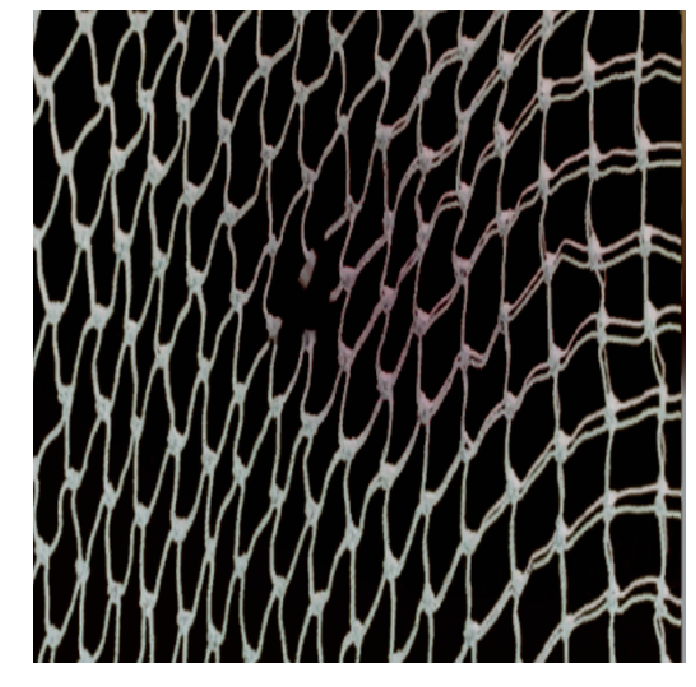

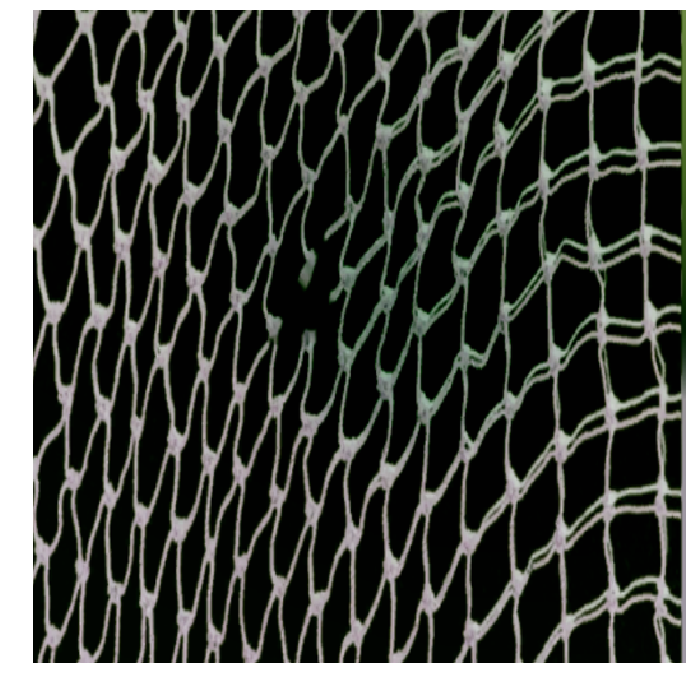

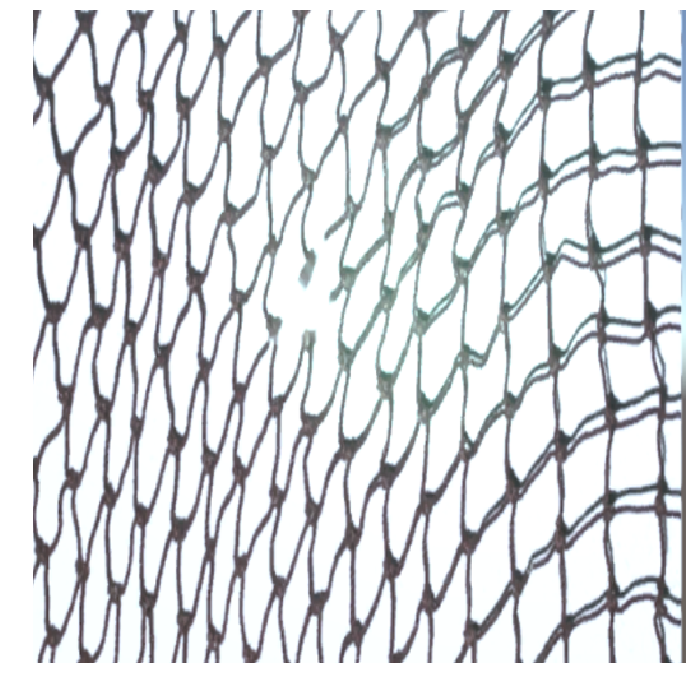

In [17]:
temp_img = tr_data[55,:].reshape([512, 512, 3])

temp2 = np.zeros((512, 512, 3))
temp2[:,:,0] = temp_img[:,:,1]
temp2[:,:,1] = temp_img[:,:,2]
temp2[:,:,2] = temp_img[:,:,0]



width = 12
height = 12
plt.figure(figsize=(width, height))
plt.axis("off")
plt.imshow(cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB))
#plt.imshow(temp_img)
plt.show()


plt.figure(figsize=(width, height))
plt.axis("off")
#plt.imshow(cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB))
plt.imshow(temp2)
plt.show()

img = cv2.imread(tr_data_dir['train'][55][0])
img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(width, height))
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#plt.imshow(img)
plt.show()   

In [33]:
i = 55

img = cv2.imread(tr_data_dir['train'][i][0])
img2 = cv2.resize(img, (512, 512), interpolation=cv2.INTER_CUBIC)


iimg = cv2.imread(tr_data_dir['train'][i][0])
iimg = cv2.resize(iimg, (512, 512), interpolation=cv2.INTER_CUBIC)

In [36]:
print(img2[:,:,2])
print(iimg[:,:,2])

[[ 83  80  81 ... 132 120 121]
 [ 83  81  81 ... 132 120 121]
 [ 84  82  82 ... 132 120 121]
 ...
 [250 251 241 ... 122 103 105]
 [250 252 240 ... 122 103 105]
 [250 252 240 ... 121 103 105]]
[[ 83  80  81 ... 132 120 121]
 [ 83  81  81 ... 132 120 121]
 [ 84  82  82 ... 132 120 121]
 ...
 [250 251 241 ... 122 103 105]
 [250 252 240 ... 122 103 105]
 [250 252 240 ... 121 103 105]]


In [32]:
temp_img = tr_data[55]
print(len(temp_img))
temp_img2 = temp_img.reshape([512, 512, 3])

print(img[:,:,2])
print(temp_img2[:,:,2])

plt.figure(figsize=(width, height))
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


786432


TypeError: 'dtype' is an invalid keyword argument for this function

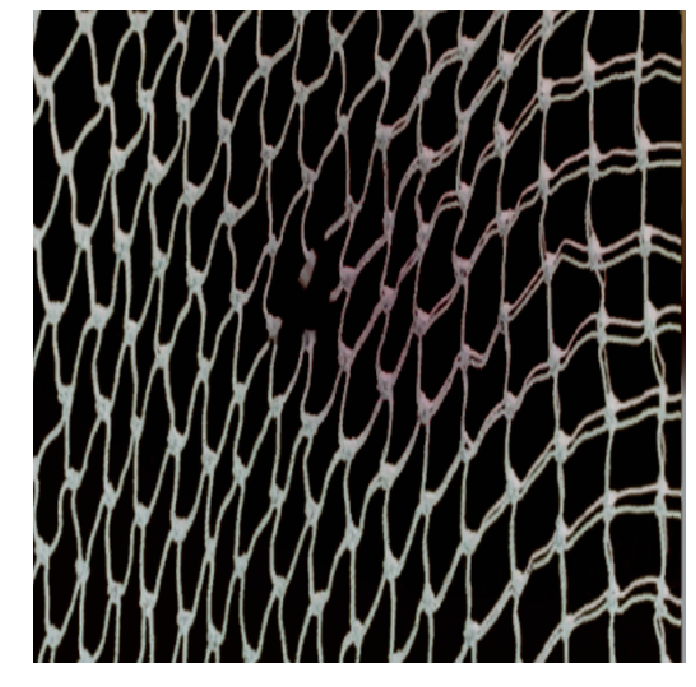

In [31]:
plt.figure(figsize=(width, height))
plt.axis("off")
plt.imshow(cv2.cvtColor(temp_img2, cv2.COLOR_BGR2RGB))

In [12]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
session = tf.Session(config=config)

ev_results = np.zeros((len(ev_label), 1))
with tf.device('/device:GPU:3'):

    # Evaluate the model and print results
    for i in range(len(ev_label)):
        eval_input_fn = tf.estimator.inputs.numpy_input_fn(
            x={"x": ev_data[i:i+1]},
            y=ev_label[i:i+1],
            num_epochs=1,
            shuffle=False)
        eval_results = net_classifier.evaluate(input_fn=eval_input_fn)
        
        ev_results[i] = eval_results["accuracy"]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:48:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:48:07
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.3518324
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:48:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:48:08
INFO:tensorflow:Saving dict for global step 1795: accuracy = 0.0, global_step = 1795, loss = 0.8349547
INFO:t

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:48:14
INFO:tensorflow:Saving dict for global step 1795: accuracy = 0.0, global_step = 1795, loss = 0.7234673
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:48:14
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:48:14
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.12600878
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:48:14
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:48:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:48:21
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.046671398
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:48:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:48:21
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.13445945
INF

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:48:27
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.2207658
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:48:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:48:28
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.20465882
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:48:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:48:34
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:48:34
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.28748682
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:48:35
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:48:35
INFO:tensorflow:Saving dict for global step 1795: accuracy = 0.0, global_step = 1795, loss = 0.78060114
INFO

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:48:41
INFO:tensorflow:Saving dict for global step 1795: accuracy = 0.0, global_step = 1795, loss = 1.0014393
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:48:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:48:41
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.18112521
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:48:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:48:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:48:48
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.3558693
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:48:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:48:48
INFO:tensorflow:Saving dict for global step 1795: accuracy = 0.0, global_step = 1795, loss = 0.7404605
INFO:t

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:48:54
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.106549576
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:48:54
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:48:55
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.16123544
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:48:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INF

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:49:01
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:49:01
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.4131643
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:49:01
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:49:01
INFO:tensorflow:Saving dict for global step 1795: accuracy = 0.0, global_step = 1795, loss = 1.2184799
INFO:t

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:49:07
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.690152
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:49:08
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:49:08
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.058452148
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:49:08
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:49:14
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:49:14
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.15321118
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:49:15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:49:15
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.1137636
INFO:

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:49:21
INFO:tensorflow:Saving dict for global step 1795: accuracy = 0.0, global_step = 1795, loss = 0.9622795
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:49:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:49:21
INFO:tensorflow:Saving dict for global step 1795: accuracy = 0.0, global_step = 1795, loss = 1.1617444
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:49:22
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:t

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:49:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:49:28
INFO:tensorflow:Saving dict for global step 1795: accuracy = 0.0, global_step = 1795, loss = 1.0670025
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:49:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:49:29
INFO:tensorflow:Saving dict for global step 1795: accuracy = 0.0, global_step = 1795, loss = 0.90486467
INFO:

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:49:35
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.4399083
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:49:35
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:49:35
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.41448045
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:49:35
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:49:42
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:49:42
INFO:tensorflow:Saving dict for global step 1795: accuracy = 0.0, global_step = 1795, loss = 1.1611391
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:49:42
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:49:42
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.54384625
INFO:

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:49:49
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.5267359
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:49:49
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:49:49
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.35476798
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:49:49
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:49:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:49:56
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.6041981
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:49:56
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:49:56
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.31537852
INFO:

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:50:02
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.63681996
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:50:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:50:03
INFO:tensorflow:Saving dict for global step 1795: accuracy = 0.0, global_step = 1795, loss = 0.9527937
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:50:03
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:50:09
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:50:09
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.39521778
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:50:09
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:50:09
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.687214
INFO:t

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:50:16
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.10286063
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:50:16
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:50:16
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.15038992
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:50:16
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:50:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:50:23
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.633116
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:50:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:50:23
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.32030508
INFO:t

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:50:29
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.30152166
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:50:29
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:50:30
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.5147419
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:50:30
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:50:36
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:50:36
INFO:tensorflow:Saving dict for global step 1795: accuracy = 0.0, global_step = 1795, loss = 0.86959505
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:50:36
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:50:37
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.2758452
INFO:

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:50:43
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.57777435
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:50:43
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:50:43
INFO:tensorflow:Saving dict for global step 1795: accuracy = 0.0, global_step = 1795, loss = 0.69620615
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:50:44
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:50:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:50:50
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.33510318
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:50:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:50:51
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.3831458
INFO:

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:50:57
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.4065922
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:50:57
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:50:57
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.04657685
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:50:58
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:51:04
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:51:04
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.41349703
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:51:04
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:51:04
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.4693503
INFO:

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:51:11
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.34041426
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:51:11
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:51:11
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.6711365
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:51:11
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:51:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:51:18
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.3145661
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:51:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:51:18
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.12057805
INFO:

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:51:25
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.046728626
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:51:25
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:51:25
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.671273
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:51:25
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:51:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:51:32
INFO:tensorflow:Saving dict for global step 1795: accuracy = 0.0, global_step = 1795, loss = 1.2673273
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:51:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:51:32
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.5420018
INFO:t

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:51:38
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.22842969
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:51:39
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:51:39
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.20408948
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:51:39
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:51:46
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:51:46
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.5812668
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:51:46
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:51:46
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.18832599
INFO:

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:51:53
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.6395386
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:51:53
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:51:53
INFO:tensorflow:Saving dict for global step 1795: accuracy = 0.0, global_step = 1795, loss = 1.059003
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:51:53
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:te

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:52:00
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:52:00
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.66699046
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:52:00
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:52:00
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.026062848
INF

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:52:07
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.07262273
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:52:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:52:07
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.31299144
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:52:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:52:14
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:52:14
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.0945974
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:52:14
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:52:14
INFO:tensorflow:Saving dict for global step 1795: accuracy = 0.0, global_step = 1795, loss = 1.1489928
INFO:t

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:52:20
INFO:tensorflow:Saving dict for global step 1795: accuracy = 0.0, global_step = 1795, loss = 1.2015684
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:52:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:52:21
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.34143668
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:52:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:52:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:52:28
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.61983615
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:52:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:52:28
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.243571
INFO:t

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:52:34
INFO:tensorflow:Saving dict for global step 1795: accuracy = 1.0, global_step = 1795, loss = 0.1813624
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:52:35
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-05-01:52:35
INFO:tensorflow:Saving dict for global step 1795: accuracy = 0.0, global_step = 1795, loss = 1.1843371
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-05-01:52:35
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /models/CNN2600-0605_RGB/model.ckpt-1795
INFO:t

In [13]:
print(np.mean(ev_results))

0.781010719754977


In [14]:
fail_idx = np.where(ev_results == 0)
print(fail_idx[0])
print(len(fail_idx[0]))

[  1   3   5   8  12  16  18  19  24  31  47  55  57  67  70  72  82  88
  91  93  95 100 109 110 113 119 125 131 133 135 139 142 144 146 157 158
 159 164 171 175 179 181 182 190 191 197 198 199 200 202 206 207 226 227
 231 235 239 246 249 253 257 259 262 274 278 281 291 294 310 312 315 319
 320 322 325 335 343 348 350 355 363 365 366 368 374 376 380 386 388 390
 392 404 408 410 411 416 421 422 431 432 436 449 453 461 464 465 475 477
 481 483 494 495 501 508 510 516 518 525 530 532 536 539 542 545 549 565
 569 575 576 581 583 584 586 587 590 595 606 610 622 638 642 644 645]
143


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(len(fail_idx[0])):

    temp_img = ev_data_sh[fail_idx[0][i]][:].reshape([480, 640, 3])

    temp_img = 255-temp_img

    width = 12
    height = 12
    plt.figure(figsize=(width, height))
    plt.axis("off")
    plt.imshow(cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB))
    plt.show()